2023-06-27 16:44:25.352016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-27 16:44:25.352855: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


163 test images found


  0%|          | 0/163 [00:00<?, ?it/s]2023-06-27 16:44:26.180030: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.
2023-06-27 16:44:26.220214: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

2023-06-27 16:44:26.478285: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.
2023-06-27 16:44:26.533813: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.
2023-06-27 16:44:26.533865: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37748736 exceeds 10% of free system memory.


1/1 [==============================] - 1s 719ms/step


  1%|          | 1/163 [00:00<02:10,  1.25it/s]

1/1 [==============================] - 0s 479ms/step


  1%|          | 2/163 [00:01<01:43,  1.55it/s]

1/1 [==============================] - 0s 445ms/step


  2%|▏         | 3/163 [00:01<01:34,  1.70it/s]

1/1 [==============================] - 0s 480ms/step


  2%|▏         | 4/163 [00:29<29:26, 11.11s/it]

1/1 [==============================] - 0s 488ms/step


  3%|▎         | 5/163 [00:31<20:55,  7.95s/it]

1/1 [==============================] - 0s 490ms/step


  4%|▎         | 6/163 [00:31<14:12,  5.43s/it]

1/1 [==============================] - 0s 463ms/step


  4%|▍         | 7/163 [02:35<1:54:43, 44.13s/it]

1/1 [==============================] - 0s 421ms/step


  5%|▍         | 8/163 [02:39<1:20:52, 31.30s/it]

1/1 [==============================] - 0s 433ms/step


  6%|▌         | 9/163 [02:40<55:36, 21.67s/it]  

1/1 [==============================] - 0s 413ms/step


  6%|▌         | 10/163 [02:40<38:33, 15.12s/it]

1/1 [==============================] - 0s 423ms/step


  7%|▋         | 11/163 [02:42<27:42, 10.94s/it]

1/1 [==============================] - 0s 438ms/step


  7%|▋         | 12/163 [02:42<19:31,  7.76s/it]

1/1 [==============================] - 0s 410ms/step


  8%|▊         | 13/163 [02:45<15:33,  6.22s/it]

1/1 [==============================] - 0s 427ms/step


  9%|▊         | 14/163 [02:46<11:45,  4.74s/it]

1/1 [==============================] - 0s 410ms/step


  9%|▉         | 15/163 [02:47<08:56,  3.62s/it]

1/1 [==============================] - 0s 399ms/step


 10%|▉         | 16/163 [02:47<06:32,  2.67s/it]

1/1 [==============================] - 0s 414ms/step


 10%|█         | 17/163 [02:48<05:06,  2.10s/it]

1/1 [==============================] - 0s 405ms/step


 11%|█         | 18/163 [02:49<03:52,  1.61s/it]

1/1 [==============================] - 0s 397ms/step


 12%|█▏        | 19/163 [02:52<05:20,  2.23s/it]

1/1 [==============================] - 0s 403ms/step


 12%|█▏        | 20/163 [02:53<04:07,  1.73s/it]

1/1 [==============================] - 0s 400ms/step


 13%|█▎        | 21/163 [02:53<03:11,  1.35s/it]

1/1 [==============================] - 0s 404ms/step


 13%|█▎        | 22/163 [02:54<02:45,  1.18s/it]

1/1 [==============================] - 0s 412ms/step


 14%|█▍        | 23/163 [02:55<02:14,  1.04it/s]

1/1 [==============================] - 0s 404ms/step


 15%|█▍        | 24/163 [02:55<01:52,  1.24it/s]

1/1 [==============================] - 0s 403ms/step


 15%|█▌        | 25/163 [03:09<10:33,  4.59s/it]

1/1 [==============================] - 0s 413ms/step


 16%|█▌        | 26/163 [03:09<07:38,  3.35s/it]

1/1 [==============================] - 0s 433ms/step


 17%|█▋        | 27/163 [03:12<07:37,  3.37s/it]

1/1 [==============================] - 0s 452ms/step


 17%|█▋        | 28/163 [03:13<05:38,  2.51s/it]

1/1 [==============================] - 0s 421ms/step


 18%|█▊        | 29/163 [03:13<04:14,  1.90s/it]

1/1 [==============================] - 0s 408ms/step


 18%|█▊        | 30/163 [03:14<03:14,  1.46s/it]

1/1 [==============================] - 0s 426ms/step


 19%|█▉        | 31/163 [03:14<02:34,  1.17s/it]

1/1 [==============================] - 0s 405ms/step


 20%|█▉        | 32/163 [03:15<02:29,  1.14s/it]

1/1 [==============================] - 0s 450ms/step


 20%|██        | 33/163 [03:16<02:03,  1.05it/s]

1/1 [==============================] - 0s 413ms/step


 21%|██        | 34/163 [03:16<01:43,  1.25it/s]

1/1 [==============================] - 0s 402ms/step


 21%|██▏       | 35/163 [03:19<02:46,  1.30s/it]

1/1 [==============================] - 0s 446ms/step


 22%|██▏       | 36/163 [03:19<02:14,  1.06s/it]

1/1 [==============================] - 0s 410ms/step


 23%|██▎       | 37/163 [03:20<02:18,  1.10s/it]

1/1 [==============================] - 0s 396ms/step


 23%|██▎       | 38/163 [03:21<02:01,  1.03it/s]

1/1 [==============================] - 0s 404ms/step


 24%|██▍       | 39/163 [03:22<01:41,  1.22it/s]

1/1 [==============================] - 0s 393ms/step


 25%|██▍       | 40/163 [03:22<01:26,  1.42it/s]

1/1 [==============================] - 0s 400ms/step


 25%|██▌       | 41/163 [03:23<01:16,  1.59it/s]

1/1 [==============================] - 0s 402ms/step


 26%|██▌       | 42/163 [03:29<04:46,  2.37s/it]

1/1 [==============================] - 0s 452ms/step


 26%|██▋       | 43/163 [03:29<03:36,  1.81s/it]

1/1 [==============================] - 0s 406ms/step


 27%|██▋       | 44/163 [03:30<02:46,  1.40s/it]

1/1 [==============================] - 0s 440ms/step


 28%|██▊       | 45/163 [03:32<02:54,  1.48s/it]

1/1 [==============================] - 0s 405ms/step


 28%|██▊       | 46/163 [03:33<02:36,  1.34s/it]

1/1 [==============================] - 0s 397ms/step


 29%|██▉       | 47/163 [03:33<02:04,  1.07s/it]

1/1 [==============================] - 0s 410ms/step


 29%|██▉       | 48/163 [03:34<01:51,  1.03it/s]

1/1 [==============================] - 0s 409ms/step


 30%|███       | 49/163 [03:34<01:38,  1.16it/s]

1/1 [==============================] - 0s 405ms/step


 31%|███       | 50/163 [03:35<01:28,  1.27it/s]

1/1 [==============================] - 0s 403ms/step


 31%|███▏      | 51/163 [03:35<01:16,  1.46it/s]

1/1 [==============================] - 0s 397ms/step


 32%|███▏      | 52/163 [03:36<01:07,  1.63it/s]

1/1 [==============================] - 1s 511ms/step


 33%|███▎      | 53/163 [04:12<20:32, 11.20s/it]

1/1 [==============================] - 0s 413ms/step


 33%|███▎      | 54/163 [04:12<14:30,  7.99s/it]

1/1 [==============================] - 0s 401ms/step


 34%|███▎      | 55/163 [04:13<10:18,  5.73s/it]

1/1 [==============================] - 0s 453ms/step


 34%|███▍      | 56/163 [04:14<07:43,  4.33s/it]

1/1 [==============================] - 0s 408ms/step


 35%|███▍      | 57/163 [04:14<05:35,  3.17s/it]

1/1 [==============================] - 0s 457ms/step


 36%|███▌      | 58/163 [04:27<10:32,  6.02s/it]

1/1 [==============================] - 0s 407ms/step


 36%|███▌      | 59/163 [04:27<07:32,  4.35s/it]

1/1 [==============================] - 0s 414ms/step


 37%|███▋      | 60/163 [04:28<05:28,  3.18s/it]

1/1 [==============================] - 0s 396ms/step


 37%|███▋      | 61/163 [04:28<04:03,  2.39s/it]

1/1 [==============================] - 0s 405ms/step


 38%|███▊      | 62/163 [05:43<40:22, 23.99s/it]

1/1 [==============================] - 0s 413ms/step


 39%|███▊      | 63/163 [05:43<28:13, 16.93s/it]

1/1 [==============================] - 0s 403ms/step


 39%|███▉      | 64/163 [05:44<19:46, 11.99s/it]

1/1 [==============================] - 0s 392ms/step


 40%|███▉      | 65/163 [05:44<13:58,  8.55s/it]

1/1 [==============================] - 0s 397ms/step


 40%|████      | 66/163 [06:06<20:19, 12.57s/it]

1/1 [==============================] - 0s 414ms/step


 41%|████      | 67/163 [06:07<14:18,  8.94s/it]

1/1 [==============================] - 0s 402ms/step


 42%|████▏     | 68/163 [06:07<10:15,  6.48s/it]

1/1 [==============================] - 0s 407ms/step


 42%|████▏     | 69/163 [06:08<07:19,  4.67s/it]

1/1 [==============================] - 0s 442ms/step


 43%|████▎     | 70/163 [06:09<05:29,  3.54s/it]

1/1 [==============================] - 0s 409ms/step


 44%|████▎     | 71/163 [06:13<05:38,  3.68s/it]

1/1 [==============================] - 0s 439ms/step


 44%|████▍     | 72/163 [06:13<04:08,  2.73s/it]

1/1 [==============================] - 0s 404ms/step


 45%|████▍     | 73/163 [06:14<03:11,  2.13s/it]

1/1 [==============================] - 0s 402ms/step


 45%|████▌     | 74/163 [06:14<02:26,  1.64s/it]

1/1 [==============================] - 0s 398ms/step


 46%|████▌     | 75/163 [06:15<01:53,  1.28s/it]

1/1 [==============================] - 0s 404ms/step


 47%|████▋     | 76/163 [06:15<01:32,  1.07s/it]

1/1 [==============================] - 0s 420ms/step


 47%|████▋     | 77/163 [06:16<01:16,  1.13it/s]

1/1 [==============================] - 0s 438ms/step


 48%|████▊     | 78/163 [08:28<56:50, 40.13s/it]

1/1 [==============================] - 1s 555ms/step


 48%|████▊     | 79/163 [08:43<45:56, 32.82s/it]

1/1 [==============================] - 1s 561ms/step


 49%|████▉     | 80/163 [08:44<32:01, 23.16s/it]

1/1 [==============================] - 1s 595ms/step


 50%|████▉     | 81/163 [08:45<22:25, 16.41s/it]

1/1 [==============================] - 1s 573ms/step


 50%|█████     | 82/163 [08:46<15:54, 11.78s/it]

1/1 [==============================] - 1s 559ms/step


 51%|█████     | 83/163 [08:46<11:14,  8.43s/it]

1/1 [==============================] - 1s 557ms/step


 52%|█████▏    | 84/163 [08:47<08:01,  6.09s/it]

1/1 [==============================] - 1s 591ms/step


 52%|█████▏    | 85/163 [08:48<05:47,  4.46s/it]

1/1 [==============================] - 1s 581ms/step


 53%|█████▎    | 86/163 [08:48<04:18,  3.36s/it]

1/1 [==============================] - 0s 445ms/step


 53%|█████▎    | 87/163 [08:49<03:10,  2.50s/it]

1/1 [==============================] - 1s 614ms/step


 54%|█████▍    | 88/163 [08:50<02:26,  1.95s/it]

1/1 [==============================] - 1s 518ms/step


 55%|█████▍    | 89/163 [08:50<01:55,  1.56s/it]

1/1 [==============================] - 1s 552ms/step


 55%|█████▌    | 90/163 [08:51<01:32,  1.27s/it]

1/1 [==============================] - 1s 554ms/step


 56%|█████▌    | 91/163 [08:51<01:19,  1.11s/it]

1/1 [==============================] - 1s 548ms/step


 56%|█████▋    | 92/163 [08:52<01:10,  1.01it/s]

1/1 [==============================] - 1s 509ms/step


 57%|█████▋    | 93/163 [08:53<01:00,  1.16it/s]

1/1 [==============================] - 1s 598ms/step


 58%|█████▊    | 94/163 [08:53<00:55,  1.24it/s]

1/1 [==============================] - 1s 564ms/step


 58%|█████▊    | 95/163 [08:54<00:51,  1.31it/s]

1/1 [==============================] - 1s 595ms/step


 59%|█████▉    | 96/163 [08:55<00:49,  1.36it/s]

1/1 [==============================] - 1s 535ms/step


 60%|█████▉    | 97/163 [08:55<00:46,  1.42it/s]

1/1 [==============================] - 1s 539ms/step


 60%|██████    | 98/163 [08:56<00:44,  1.48it/s]

1/1 [==============================] - 1s 528ms/step


 61%|██████    | 99/163 [08:57<00:41,  1.54it/s]

1/1 [==============================] - 1s 569ms/step


 61%|██████▏   | 100/163 [08:57<00:40,  1.55it/s]

1/1 [==============================] - 1s 564ms/step


 62%|██████▏   | 101/163 [08:58<00:41,  1.49it/s]

1/1 [==============================] - 0s 482ms/step


 63%|██████▎   | 102/163 [08:59<00:38,  1.58it/s]

1/1 [==============================] - 1s 546ms/step


 63%|██████▎   | 103/163 [08:59<00:37,  1.60it/s]

1/1 [==============================] - 1s 587ms/step


 64%|██████▍   | 104/163 [09:00<00:41,  1.42it/s]

1/1 [==============================] - 1s 631ms/step


 64%|██████▍   | 105/163 [09:05<01:46,  1.84s/it]

1/1 [==============================] - 1s 556ms/step


 65%|██████▌   | 106/163 [09:16<04:24,  4.64s/it]

1/1 [==============================] - 1s 605ms/step


 66%|██████▌   | 107/163 [09:39<09:25, 10.10s/it]

1/1 [==============================] - 1s 595ms/step


 66%|██████▋   | 108/163 [09:39<06:39,  7.27s/it]

1/1 [==============================] - 0s 482ms/step


 67%|██████▋   | 109/163 [09:40<04:43,  5.25s/it]

1/1 [==============================] - 1s 552ms/step


 67%|██████▋   | 110/163 [09:40<03:24,  3.87s/it]

1/1 [==============================] - 1s 541ms/step


 68%|██████▊   | 111/163 [09:41<02:30,  2.89s/it]

1/1 [==============================] - 1s 524ms/step


 69%|██████▊   | 112/163 [09:42<01:52,  2.20s/it]

1/1 [==============================] - 1s 539ms/step


 69%|██████▉   | 113/163 [09:42<01:26,  1.73s/it]

1/1 [==============================] - 1s 646ms/step


 70%|██████▉   | 114/163 [09:43<01:09,  1.42s/it]

1/1 [==============================] - 1s 565ms/step


 71%|███████   | 115/163 [09:44<00:56,  1.19s/it]

1/1 [==============================] - 1s 560ms/step


 71%|███████   | 116/163 [09:44<00:47,  1.02s/it]

1/1 [==============================] - 1s 643ms/step


 72%|███████▏  | 117/163 [09:45<00:42,  1.08it/s]

1/1 [==============================] - 1s 601ms/step


 72%|███████▏  | 118/163 [09:47<00:58,  1.29s/it]

1/1 [==============================] - 1s 615ms/step


 73%|███████▎  | 119/163 [09:48<00:55,  1.25s/it]

1/1 [==============================] - 1s 561ms/step


 74%|███████▎  | 120/163 [09:51<01:07,  1.57s/it]

1/1 [==============================] - 1s 533ms/step


 74%|███████▍  | 121/163 [09:51<00:56,  1.33s/it]

1/1 [==============================] - 1s 538ms/step


 75%|███████▍  | 122/163 [09:52<00:46,  1.12s/it]

1/1 [==============================] - 1s 585ms/step


 75%|███████▌  | 123/163 [09:53<00:45,  1.14s/it]

1/1 [==============================] - 1s 637ms/step


 76%|███████▌  | 124/163 [09:54<00:39,  1.01s/it]

1/1 [==============================] - 1s 577ms/step


 77%|███████▋  | 125/163 [09:57<01:06,  1.75s/it]

1/1 [==============================] - 1s 557ms/step


 77%|███████▋  | 126/163 [09:58<00:54,  1.48s/it]

1/1 [==============================] - 1s 587ms/step


 78%|███████▊  | 127/163 [09:59<00:45,  1.27s/it]

1/1 [==============================] - 1s 582ms/step


 79%|███████▊  | 128/163 [10:00<00:37,  1.08s/it]

1/1 [==============================] - 1s 524ms/step


 79%|███████▉  | 129/163 [10:39<07:07, 12.57s/it]

1/1 [==============================] - 0s 469ms/step


 80%|███████▉  | 130/163 [10:40<04:56,  8.97s/it]

1/1 [==============================] - 0s 445ms/step


 80%|████████  | 131/163 [10:40<03:26,  6.44s/it]

1/1 [==============================] - 0s 496ms/step


 81%|████████  | 132/163 [10:41<02:26,  4.72s/it]

1/1 [==============================] - 0s 451ms/step


 82%|████████▏ | 133/163 [10:41<01:44,  3.47s/it]

1/1 [==============================] - 0s 463ms/step


 82%|████████▏ | 134/163 [10:42<01:15,  2.59s/it]

1/1 [==============================] - 0s 465ms/step


 83%|████████▎ | 135/163 [10:43<00:57,  2.06s/it]

1/1 [==============================] - 0s 419ms/step


 83%|████████▎ | 136/163 [10:43<00:43,  1.61s/it]

1/1 [==============================] - 0s 417ms/step


 84%|████████▍ | 137/163 [10:44<00:33,  1.28s/it]

1/1 [==============================] - 0s 420ms/step


 85%|████████▍ | 138/163 [10:44<00:28,  1.12s/it]

1/1 [==============================] - 0s 434ms/step


 85%|████████▌ | 139/163 [10:45<00:25,  1.06s/it]

1/1 [==============================] - 0s 430ms/step


 86%|████████▌ | 140/163 [10:46<00:22,  1.02it/s]

1/1 [==============================] - 0s 400ms/step


 87%|████████▋ | 141/163 [10:47<00:19,  1.14it/s]

1/1 [==============================] - 0s 402ms/step


 87%|████████▋ | 142/163 [10:48<00:17,  1.20it/s]

1/1 [==============================] - 0s 399ms/step


 88%|████████▊ | 143/163 [10:48<00:16,  1.19it/s]

1/1 [==============================] - 0s 406ms/step


 88%|████████▊ | 144/163 [10:49<00:15,  1.24it/s]

1/1 [==============================] - 0s 402ms/step


 89%|████████▉ | 145/163 [10:50<00:15,  1.19it/s]

1/1 [==============================] - 0s 406ms/step


 90%|████████▉ | 146/163 [10:51<00:15,  1.13it/s]

1/1 [==============================] - 0s 434ms/step


 90%|█████████ | 147/163 [10:52<00:12,  1.26it/s]

1/1 [==============================] - 0s 459ms/step


 91%|█████████ | 148/163 [10:52<00:12,  1.24it/s]

1/1 [==============================] - 0s 463ms/step


 91%|█████████▏| 149/163 [10:53<00:10,  1.37it/s]

1/1 [==============================] - 0s 485ms/step


 92%|█████████▏| 150/163 [10:54<00:09,  1.36it/s]

1/1 [==============================] - 0s 500ms/step


 93%|█████████▎| 151/163 [10:58<00:21,  1.75s/it]

1/1 [==============================] - 1s 615ms/step


 93%|█████████▎| 152/163 [10:59<00:17,  1.56s/it]

1/1 [==============================] - 0s 418ms/step


 94%|█████████▍| 153/163 [11:00<00:13,  1.31s/it]

1/1 [==============================] - 0s 425ms/step


 94%|█████████▍| 154/163 [11:00<00:10,  1.13s/it]

1/1 [==============================] - 0s 450ms/step


 95%|█████████▌| 155/163 [11:05<00:16,  2.09s/it]

1/1 [==============================] - 0s 463ms/step


 96%|█████████▌| 156/163 [11:06<00:11,  1.71s/it]

1/1 [==============================] - 0s 471ms/step


 96%|█████████▋| 157/163 [11:06<00:08,  1.36s/it]

1/1 [==============================] - 0s 483ms/step


 97%|█████████▋| 158/163 [11:07<00:05,  1.19s/it]

1/1 [==============================] - 0s 443ms/step


 98%|█████████▊| 159/163 [11:07<00:03,  1.01it/s]

1/1 [==============================] - 1s 510ms/step


 98%|█████████▊| 160/163 [11:11<00:05,  1.73s/it]

1/1 [==============================] - 1s 607ms/step


 99%|█████████▉| 161/163 [11:12<00:02,  1.42s/it]

1/1 [==============================] - 0s 433ms/step


 99%|█████████▉| 162/163 [11:12<00:01,  1.21s/it]

1/1 [==============================] - 0s 424ms/step


100%|██████████| 163/163 [11:13<00:00,  4.13s/it]


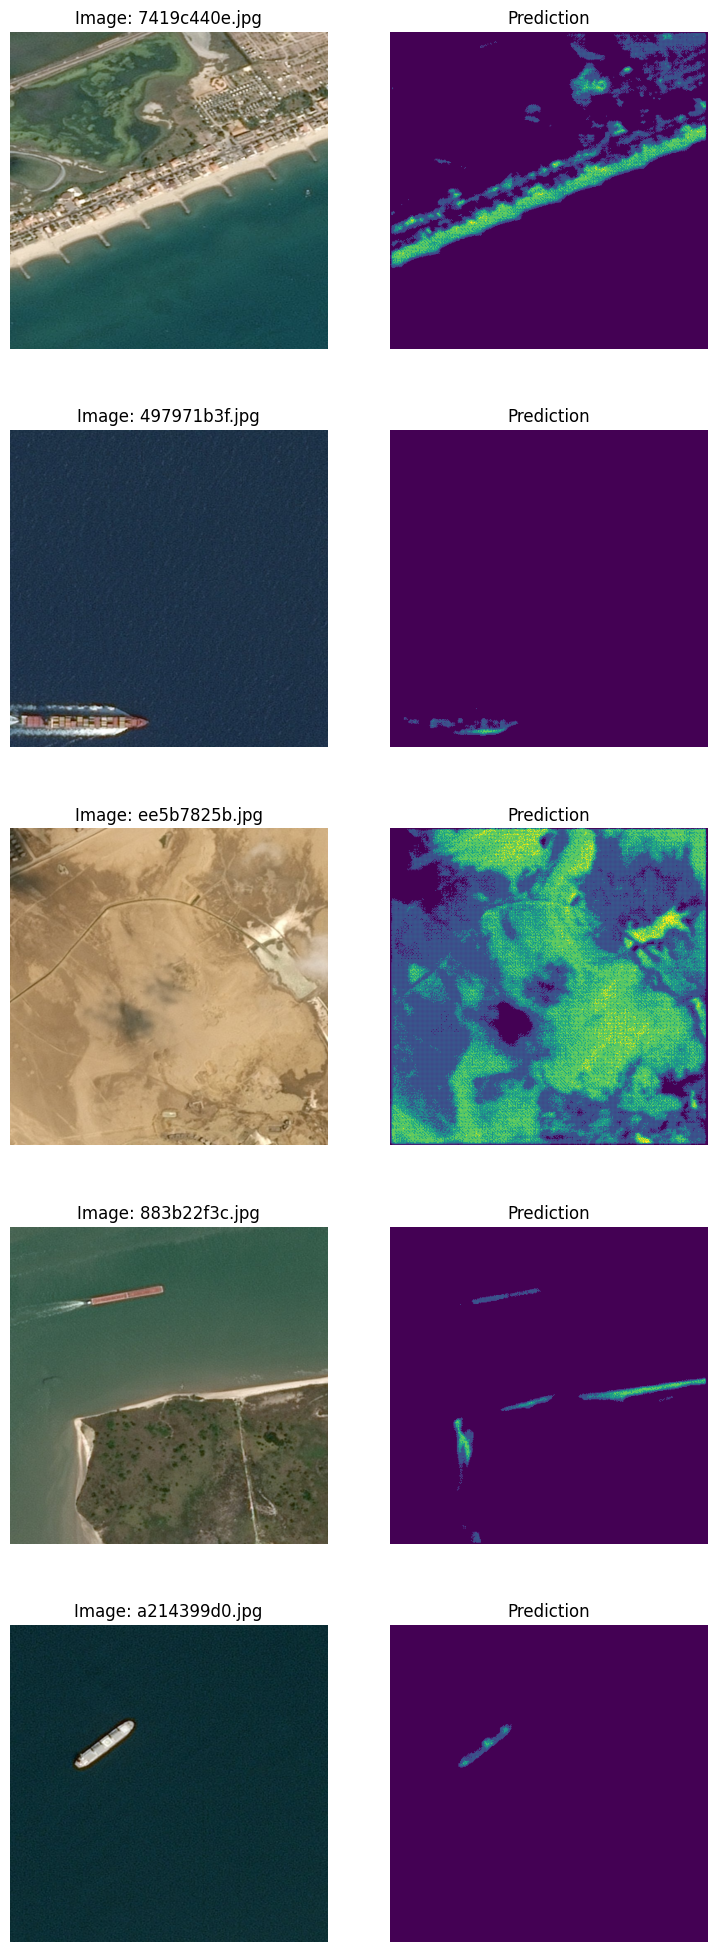

In [3]:
import os
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import keras.backend as K

from skimage.io import imread
from keras.models import load_model
from tqdm import tqdm
from skimage.morphology import label
from keras.losses import binary_crossentropy

##Dice coefficient
def dice_coef(y_true, y_pred, smooth=0.0001):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2.0 * intersection + smooth) / (union + smooth), axis=0)


def dice_p_bce(in_gt, in_pred):
    return 1e-3 * binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

test_image_dir = '../data/test_samples/'

# loading needed model
model = load_model("../app/segmentation_model.h5", custom_objects={'dice_coef':dice_coef,'dice_p_bce':                   
dice_p_bce})

# Run the test data
test_paths = os.listdir(test_image_dir)
print(len(test_paths), "test images found")

def multi_rle_encode(img):
    """
    Encode connected regions as separated masks
    """
    labels = label(img[:, :, 0])
    return [rle_encode(labels == k) for k in np.unique(labels[labels > 0])]


# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(768, 768)):
    """
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype=np.float32)
    # if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)


def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, img))
    c_img = np.expand_dims(c_img, 0) / 255.0
    cur_seg = model.predict(c_img)[0]
    return cur_seg, c_img[0]


def pred_encode(img):
    cur_seg, _ = raw_prediction(img)
    cur_rles = multi_rle_encode(cur_seg)
    return [[img, rle] for rle in cur_rles if rle is not None]


out_pred_rows = []
for c_img_name in tqdm(test_paths):
    out_pred_rows += pred_encode(c_img_name)

sub = pd.DataFrame(out_pred_rows)
sub.columns = ["ImageId", "EncodedPixels"]
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

TOP_PREDICTIONS=5
fig, m_axs = plt.subplots(TOP_PREDICTIONS, 2, figsize = (9, TOP_PREDICTIONS*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), c_img_name in zip(m_axs, sub.ImageId.unique()[:TOP_PREDICTIONS]):
    c_img = imread(os.path.join(test_image_dir, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_image(sub.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels']))
    ax2.set_title('Prediction')